<a href="https://colab.research.google.com/github/abhilashhn1993/What-does-my-cousin-tweet-/blob/master/Tweet-Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GetoldTweets3
!pip install spacy
!pip install pyLDAvis

In [2]:
import GetOldTweets3 as got
import re
import string
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import os

from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['AB_Tweets.csv']))

In [ ]:
df.head()

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [8]:
#Adding Extra Stopwords to be removed from the dataset
stop_words.extend(['http', 'https', 'twitter', 'www', 'instagram', 'com'])
stop_words.extend(['make','say','go','bit','know','look','need','want','much','with','even','give','day','come','many','thing','well'])

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

def remove_stopwords(text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]

def convert_to_string(df):
  for row in range(len(df)):
    df.iloc[row].Tweets = ' '.join([str(element) for element in df.iloc[row].Tweets])
  return df

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Emails
df['Tweets'] = [re.sub('\S*@\S*\s?', '', sent) for sent in df['Tweets']]
# Remove new line characters
df['Tweets'] = [re.sub('\s+', ' ', sent) for sent in df['Tweets']]
# Remove distracting single quotes
df['Tweets'] = [re.sub("\'", "", sent) for sent in df['Tweets']]
#Remove consecutive characters
df['Tweets'] = np.vectorize(remove_pattern)(df['Tweets'], "@[\w]*")

In [ ]:
df['Tweets'] = list(sent_to_words(df['Tweets']))
df['Tweets'] = remove_stopwords(df['Tweets'])
df.head()

In [12]:
nlp = spacy.load('en', disable=['parser', 'ner'])
df['Tweets'] = lemmatization(df['Tweets'], allowed_postags=['NOUN','ADJ','VERB','ADV'])

In [13]:
df['Tweets'] = remove_stopwords(df['Tweets'])

In [14]:
df = convert_to_string(df)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df['Tweets'] = df['Tweets'].str.join(" ")
df.head()

In [16]:
words = ' '.join([text for text in df['Tweets']])

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

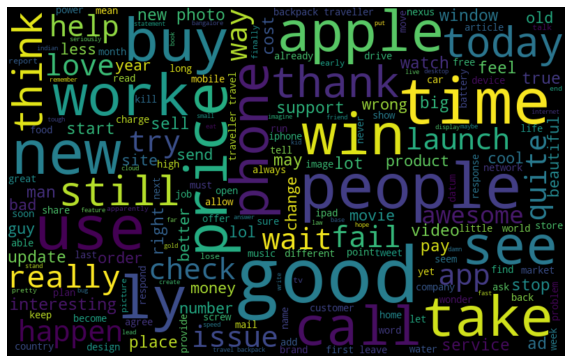

In [18]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [19]:
# function to collect hashtags
def hashtag_extract(df):
    hashtags = df.loc[df['Hashtags'].notnull() , ['Hashtags']]
    hashtags = hashtags['Hashtags'].tolist()
    hashtags = extract_hashtags_seperate(hashtags)
    return hashtags

In [20]:
def extract_hashtags_seperate(x):
  aList = []
  for i in x:
    ht = re.findall(r"#(\w+)", i)
    aList.append(ht)
  return aList

In [21]:
tweet_hashtags = hashtag_extract(df)

In [22]:
tweet_hashtags = sum(tweet_hashtags, [])

In [ ]:
print(tweet_hashtags)

In [24]:
tags = nltk.FreqDist(tweet_hashtags)

In [25]:
htags_data = pd.DataFrame({'Hashtag': list(tags.keys()),
                  'Count': list(tags.values())})

In [ ]:
htags_data.sort_values(by=['Count'], ascending=False)

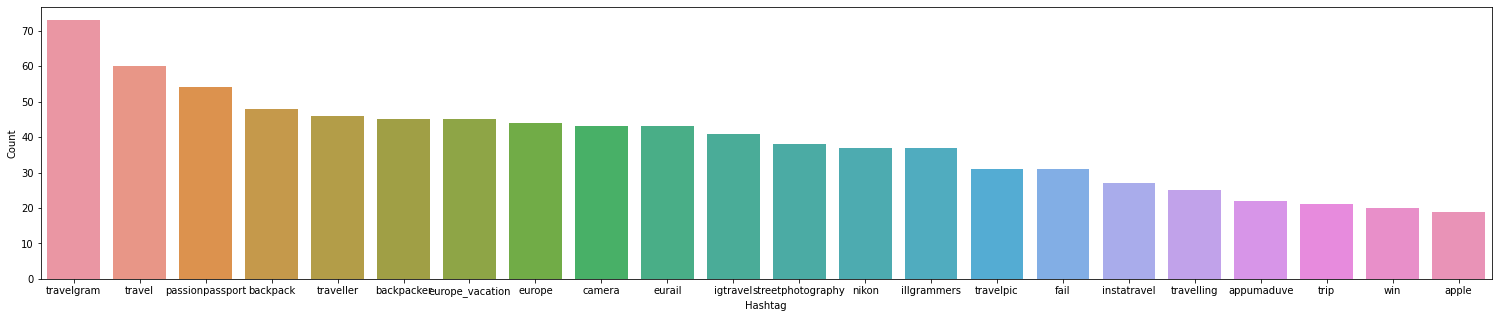

In [27]:
# selecting top 10 most frequent hashtags     
htags = htags_data.nlargest(columns="Count", n = 22) 
plt.figure(figsize=(26,5))
ax = sns.barplot(data=htags, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

**LDA Topic Modeling**

In [28]:
df['Tweets'] = list(sent_to_words(df['Tweets']))
df['Tweets'] = remove_stopwords(df['Tweets'])
df['Tweets'] = lemmatization(df['Tweets'], allowed_postags=['NOUN','ADJ','VERB','ADV'])
df['Tweets'] = remove_stopwords(df['Tweets'])

In [ ]:
data_lemmatized = df['Tweets']
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [ ]:
print(data_lemmatized)

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.054464  0.162678       1        1  15.695475
1     -0.107547 -0.219840       2        1  15.375833
0      0.260220 -0.045975       3        1  15.353201
6     -0.030389  0.037960       4        1  14.526545
2     -0.029596  0.040493       5        1  13.921731
3     -0.020598  0.010867       6        1  12.773448
5     -0.017626  0.013816       7        1  12.353767, topic_info=        Term        Freq       Total Category  logprob  loglift
108     good  172.000000  172.000000  Default  30.0000  30.0000
89      time   97.000000   97.000000  Default  29.0000  29.0000
9        use   79.000000   79.000000  Default  28.0000  28.0000
90     would   73.000000   73.000000  Default  27.0000  27.0000
3      check   73.000000   73.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1715   build   12.340065   13.169390   Topic7  -5.1156   2.0262
756   credit   11.899301   12.722555   Topic7  -5.1520   2.0243
382     card   11.842296   12.665029   Topic7  -5.1568   2.0240
41     ahead   11.821505   12.649017   Topic7  -5.1586   2.0235
1716    firm   11.779890   12.604768   Topic7  -5.1621   2.0235

[241 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
250       1  0.975824      ad
0         6  0.980079     add
436       7  0.959416   agree
41        7  0.948690   ahead
679       4  0.942010  almost
...     ...       ...     ...
860       2  0.939438    word
59        2  0.988763    work
967       3  0.972855   world
90        4  0.990374   would
302       4  0.973558    year

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 7, 3, 4, 6])